In [11]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym
import numpy as np
import os

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available(
) else 'mps' if torch.backends.mps.is_available() else "cpu")
# Macbook CPU performed much better than hyperion gpu
device = 'cpu'

In [56]:
class Memory:
    """Stores the agent's experiences during training."""

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []

    def clear_memory(self):
        """Clears all stored experiences."""
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.is_terminals.clear()
        self.logprobs.clear()

In [31]:
class ActorCritic(nn.Module):
    """Actor-Critic network model."""

    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def act(self, state, memory):
        """Determines the next action and updates memory with action probability."""
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)

        return action.item()

    def evaluate(self, state, action):
        """Evaluates actions and states using the critic and actor networks."""
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [35]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr, betas, gamma, K_epochs, eps_clip, device, ckpt=None, restore=False):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.device = device

        self.memory = Memory()

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.old_policy = ActorCritic(state_dim, action_dim).to(device)
        self.old_policy.load_state_dict(self.policy.state_dict())

        if restore and ckpt is not None:
            self.load_checkpoint(ckpt)

        self.optimizer = torch.optim.Adam(
            self.policy.parameters(), lr=lr, betas=betas)
        self.MSE_loss = nn.MSELoss()

    def select_action(self, state, memory):
        state_tensor = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.old_policy.act(state_tensor, memory)

    def update_policy(self, memory):

        rewards, old_states, old_actions, old_logprobs = self.prepare_data(
            memory)

        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(
                old_states, old_actions)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()
            self.optimize_policy(ratios, advantages,
                                 dist_entropy, state_values, rewards)

        self.old_policy.load_state_dict(self.policy.state_dict())
        memory.clear_memory()

    def prepare_data(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        old_states = torch.squeeze(torch.stack(
            memory.states).to(device)).detach()
        old_actions = torch.squeeze(torch.stack(
            memory.actions).to(device)).detach()
        old_logprobs = torch.squeeze(torch.stack(
            memory.logprobs).to(device)).detach()

        return rewards, old_states, old_actions, old_logprobs

    def optimize_policy(self, ratios, advantages, dist_entropy, state_values, rewards):
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1 - self.eps_clip,
                            1 + self.eps_clip) * advantages
        actor_loss = -torch.min(surr1, surr2)
        critic_loss = 0.5 * \
            self.MSE_loss(state_values, rewards.unsqueeze(1)) - \
            0.01 * dist_entropy
        loss = actor_loss + critic_loss

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()

    def load_checkpoint(self, ckpt_path):
        model = torch.load(ckpt_path, map_location=self.device)
        self.policy.load_state_dict(model)

In [42]:
def train(env, lr, gamma, K_epochs, eps_clip, ckpt_folder, restore, max_episodes, max_timesteps,
          update_timesteps, env_name, print_interval=10, print_api_interval=10, save_interval=100):
    agent = PPOAgent(
        state_dim=env.observation_space.shape[0],
        action_dim=env.action_space.n,
        lr=lr,
        betas=[0.9, 0.999],
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip,
        device=device,
        ckpt=ckpt_folder + '/PPO_discrete_' + env_name + '.pth',
        restore=restore
    )

    memory = Memory()
    all_rewards = []
    running_reward = 0
    avg_length = 0

    for i_episode in range(1, max_episodes + 1):
        state, _ = env.reset()
        episode_reward = 0

        for t in range(max_timesteps):
            action = agent.select_action(state, memory)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            episode_reward += reward

            if memory.states and len(memory.states) % update_timesteps == 0:
                agent.update_policy(memory)

            if done:
                break

        running_reward += episode_reward
        all_rewards.append(episode_reward)
        avg_length += t

        if i_episode % print_interval == 0:
            avg_length /= print_interval
            running_reward /= print_api_interval
            print(
                f'Episode {i_episode}\tAverage Length: {avg_length:.2f}\tAverage Reward: {running_reward:.2f}')
            running_reward = 0
            avg_length = 0

        if save_interval and i_episode % save_interval == 0:
            torch.save(agent.policy.state_dict(), ckpt_folder +
                       '/PPO_{}.pth'.format(env_name))
            print(f'Saved checkpoint at episode {i_episode}')
    return all_rewards

In [43]:
opt = {
    'env_name': 'LunarLander-v2',
    'print_interval': 10,
    'save_interval': 100,
    'max_episodes': 10000,
    'max_timesteps': 300,
    'update_timesteps': 2000,
    'K_epochs': 4,
    'eps_clip': 0.2,
    'gamma': 0.99,
    'lr': 0.002,
    'seed': 123,
    'ckpt_folder': './checkpoints',
    'restore': False
}

if not os.path.exists(opt['ckpt_folder']):
    os.mkdir(opt['ckpt_folder'])

print("Random Seed: {}".format(opt['seed']))
torch.manual_seed(opt['seed'])
np.random.seed(opt['seed'])

env_name = opt['env_name']
env = gym.make(env_name)
env.observation_space.seed(opt["seed"])
del opt['seed']
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print('Environment: {}\nState Size: {}\nAction Size: {}\n'.format(
    env_name, state_dim, action_dim))

all_rewards = train(env, **opt)

Random Seed: 123
Environment: LunarLander-v2
State Size: 8
Action Size: 4

Episode 10	Average Length: 85.30	Average Reward: -247.83


/Users/youssefshaarawy/venvs/drl/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 20	Average Length: 94.50	Average Reward: -161.43
Episode 30	Average Length: 85.00	Average Reward: -210.17


/Users/youssefshaarawy/venvs/drl/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2000, 1])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 40	Average Length: 94.50	Average Reward: -196.23
Episode 50	Average Length: 93.50	Average Reward: -174.57
Episode 60	Average Length: 93.10	Average Reward: -124.44
Episode 70	Average Length: 100.90	Average Reward: -156.34
Episode 80	Average Length: 81.70	Average Reward: -107.67
Episode 90	Average Length: 93.60	Average Reward: -162.41
Episode 100	Average Length: 83.80	Average Reward: -111.90
Saved checkpoint at episode 100
Episode 110	Average Length: 89.40	Average Reward: -124.16
Episode 120	Average Length: 93.90	Average Reward: -118.84
Episode 130	Average Length: 88.50	Average Reward: -130.18
Episode 140	Average Length: 85.00	Average Reward: -112.73
Episode 150	Average Length: 89.50	Average Reward: -133.52
Episode 160	Average Length: 87.40	Average Reward: -130.49
Episode 170	Average Length: 94.20	Average Reward: -104.30
Episode 180	Average Length: 97.10	Average Reward: -106.45
Episode 190	Average Length: 106.30	Average Reward: -125.27
Episode 200	Average Length: 117.30	Average R

In [44]:
print(len(all_rewards))

10000


In [49]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

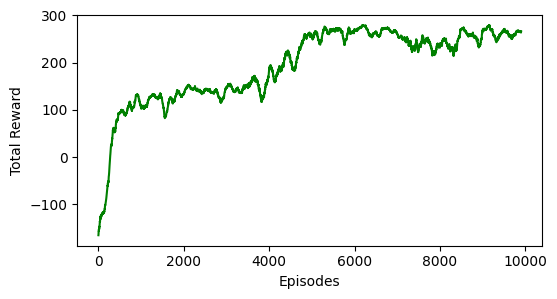

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')

plt.plot(moving_average(all_rewards, 100), color='g')

plt.show()